## Model Name: Introduction to Programming
## Model Number: CASA0013
## Student id: 20072077
## Title: A study of relationship between Airbnb listings, rent and house price in London
## Word count: 1154

## Executive Summary


There are many debates on the sharing economy with inequality, the impact to neighbours and impact to local residence. 
Airbnb host enjoys the development of tourism and the higher income generated from short rent than long term rent. At the same time residence with the need of rent home and buy house suffers a lot from the reduced house supply and price increase in the market. 

By study for the both specific borough area and the clustering of whole London. This research has main findings of: 
    
1.	Airbnb listings are tourists centred. Inner London has 35% of Airbnb listings of whole London. There are less and even no listings in some of the outer London area.
2.	Both Airbnb, rent and house price are decrease progressively from central London spread to outer London. 
3.	Number of Airbnb listings and price of listings would affect house price and rental price at the same direction.

The suggestion to the government is that it is the urgent need of policies for central areas to control the rental and house price. The other possible method is to increase the number of social homes typically in inner London. 


## Reproducible Analysis

#### Load packages

In [110]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap


import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))


#### Plot MSOA map

<AxesSubplot:>

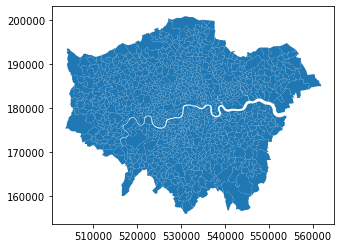

In [2]:
msoas = gpd.read_file('https://github.com/RuoxuanHong/i2pAssessment/blob/main/London_MSOAs.gpkg?raw=true')
msoas.plot()

#### Data cleaning

In [4]:
cols = ['id','name','price','latitude','longitude','room_type']
df = pd.read_csv(os.path.join('https://github.com/RuoxuanHong/i2pAssessment/blob/main/20190409listings.csv?raw=true'), usecols=cols, low_memory=False)

In [5]:
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

(79671, 6)


In [6]:
df.drop(df[df['price'] < 5].index, axis=0, inplace=True)
print(df.shape)

(79647, 6)


#### Add geomatry

In [7]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

Add lacal authority name

In [8]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

In [9]:
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')
print(gdf_la.columns.values)

['id' 'name' 'latitude' 'longitude' 'room_type' 'price' 'geometry'
 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [10]:
print(gdf_la.shape)
gdf_la.sample(3, random_state=42)[['id','name','NAME']]

(79647, 13)


,id,name,NAME
7110,4926992,"One Bedroom Flat, Willoughby,WC1A",Camden
4230,2803155,Spacious room near Emirates,Islington
15722,9966227,Lovely double in friendly house,Merton


In [11]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True) 
gdf_la.NAME.unique()

array(['Islington', 'Kensington and Chelsea', 'Westminster', 'Wandsworth',
       'Barnet', 'Newham', 'Hounslow', 'Camden', 'Richmond upon Thames',
       'Haringey', 'Hackney', 'Southwark', 'Croydon', 'Tower Hamlets',
       'Hammersmith and Fulham', 'Waltham Forest', 'Brent', 'Lambeth',
       'Ealing', 'Merton', 'Lewisham', 'Bromley', 'Havering', 'Enfield',
       'City of London', 'Barking and Dagenham', 'Greenwich',
       'Hillingdon', 'Harrow', 'Redbridge', 'Bexley',
       'Kingston upon Thames', 'Sutton', nan], dtype=object)

Drop name is NA

In [12]:
gdf[gdf_la.NAME.isna()][['id','name']]

,id,name
72150,31859004,"Double room in airy flat near O2, with terrace"
74736,32541712,???Super Central ???Thames Views ???Balcony ??...
75760,32786293,"Gated Studio near Olympic Park, 6 min to tube"
76186,32899782,South Bank - The Complete Package
76494,32988347,LONDON BRIDGE TOWER BRIDGE CITY GROUND FLOORLA...
77889,33344037,Canal view Modern Suite in East London
77911,33354457,Riverbank Apartment 2
78084,33391020,Riverside Penthouse - Amazing Views - Sleeps 4
78295,33435856,Riverview Penthouse Spacious Double Room
78477,33471621,Private room+garden cabin close to Hampton Court


<AxesSubplot:>

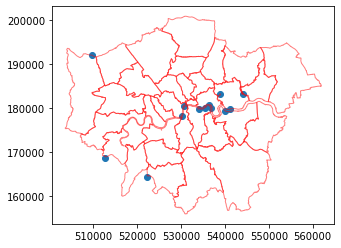

In [13]:
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

In [14]:
gdf_la.drop(index=gdf[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(gdf_la.shape)

(79634, 9)


PLot Airbnb Listings on map

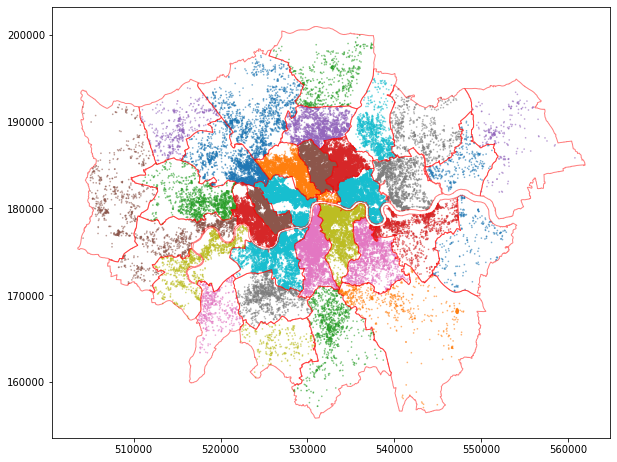

In [15]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

In [16]:
gdf_la

,id,name,latitude,longitude,room_type,price,geometry,NAME,GSS_CODE
0,13913,Holiday London DB Room Let-on going,51.56802,-0.11121,Private room,65,POINT (531005.968 187150.843),Islington,E09000019
1,15400,Bright Chelsea Apartment. Chelsea!,51.48796,-0.16898,Entire home/apt,100,POINT (527225.119 178145.995),Kensington and Chelsea,E09000020
2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,51.52098,-0.14002,Entire home/apt,500,POINT (529142.355 181868.619),Westminster,E09000033
3,24328,Battersea 2 bedroom house & parking,51.47298,-0.16376,Entire home/apt,175,POINT (527629.296 176489.244),Wandsworth,E09000032
4,25023,All-comforts 2-bed flat near Wimbledon tennis,51.44687,-0.21874,Entire home/apt,65,POINT (523881.657 173491.396),Wandsworth,E09000032
...,...,...,...,...,...,...,...,...,...
79666,33716082,Private double room with garden in central Camden,51.54661,-0.14507,Private room,48,POINT (528719.751 184709.887),Camden,E09000007
79667,33716105,Stunning king sized room with private balcony,51.42197,-0.21979,Private room,79,POINT (523875.974 170720.657),Merton,E09000024
79668,33716714,???Double Studio Hyde Park For Couple???,51.51527,-0.18335,Entire home/apt,75,POINT (526152.105 181158.125),Westminster,E09000033
79669,33716959,Modern En-suite bedroom with free Parking,51.50360,-0.42491,Private room,50,POINT (509419.453 179471.960),Hillingdon,E09000017


In [17]:
print(type(gdf_la))

<class 'geopandas.geodataframe.GeoDataFrame'>


#### Group data

In [18]:
la_data = gdf_la.groupby(['NAME'])
print(type(la_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [19]:
la_data.head()

,id,name,latitude,longitude,room_type,price,geometry,NAME,GSS_CODE
0,13913,Holiday London DB Room Let-on going,51.56802,-0.11121,Private room,65,POINT (531005.968 187150.843),Islington,E09000019
1,15400,Bright Chelsea Apartment. Chelsea!,51.48796,-0.16898,Entire home/apt,100,POINT (527225.119 178145.995),Kensington and Chelsea,E09000020
2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,51.52098,-0.14002,Entire home/apt,500,POINT (529142.355 181868.619),Westminster,E09000033
3,24328,Battersea 2 bedroom house & parking,51.47298,-0.16376,Entire home/apt,175,POINT (527629.296 176489.244),Wandsworth,E09000032
4,25023,All-comforts 2-bed flat near Wimbledon tennis,51.44687,-0.21874,Entire home/apt,65,POINT (523881.657 173491.396),Wandsworth,E09000032
...,...,...,...,...,...,...,...,...,...
2261,1052279,Cozy room 25 min from Victoria st.,51.37529,-0.15511,Private room,16,POINT (528503.536 165640.983),Sutton,E09000029
2637,1336578,Badgers Mount ..home near London,51.35368,-0.17553,Entire home/apt,220,POINT (527142.166 163202.356),Sutton,E09000029
2978,1624107,Spacious flat & great links,51.36873,-0.16510,Private room,60,POINT (527826.525 164894.054),Sutton,E09000029
3020,1666469,double room,51.37947,-0.23451,Private room,35,POINT (522966.385 165969.767),Sutton,E09000029


In [20]:
la_data.name.count()

NAME
Barking and Dagenham       299
Barnet                    1487
Bexley                     242
Brent                     2324
Bromley                    637
Camden                    5573
City of London             438
Croydon                   1039
Ealing                    1567
Enfield                    577
Greenwich                 1556
Hackney                   5965
Hammersmith and Fulham    3976
Haringey                  2030
Harrow                     442
Havering                   221
Hillingdon                 562
Hounslow                   976
Islington                 4933
Kensington and Chelsea    5697
Kingston upon Thames       501
Lambeth                   4654
Lewisham                  2209
Merton                    1299
Newham                    1857
Redbridge                  645
Richmond upon Thames      1141
Southwark                 4680
Sutton                     252
Tower Hamlets             7642
Waltham Forest            1290
Wandsworth                4039
Wes

In [21]:
# Inner West London Airbnb Listings counts
Wandsworth = 4039
Kensington = 5697
Hammersmith= 3976
Westminster= 8857
Camden =5573
InnerWcount= Wandsworth+ Kensington+Hammersmith+Westminster+Camden
print('The total Airbnb listings in Inner West London is')
print(InnerWcount)

The total Airbnb listings in Inner West London is
28142


#### calculate some index for this dataset

In [22]:
la_data2 = gdf_la.groupby(['NAME','room_type']).agg(
    {'price':['count','sum','mean','median','std',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]}
).reset_index()

In [23]:
la_data2.sample(3, random_state=42)

NAME     room_type price                           \
                                       count    sum       mean median   
62  Kingston upon Thames   Shared room     2     65  32.500000   32.5   
40              Haringey  Private room  1139  48965  42.989464   35.0   
95            Wandsworth   Shared room    10    503  50.300000   50.0   

                                     
          std <lambda_0> <lambda_1>  
62  10.606602      28.75      36.25  
40  45.824548      28.00      47.50  
95  35.755497      17.75      66.75

In [24]:
la_data2

NAME        room_type price                              \
                                          count      sum        mean median   
0   Barking and Dagenham  Entire home/apt    91     9348  102.725275   80.0   
1   Barking and Dagenham     Private room   201     9297   46.253731   35.0   
2   Barking and Dagenham      Shared room     7      420   60.000000   40.0   
3                 Barnet  Entire home/apt   590    65428  110.894915   90.0   
4                 Barnet     Private room   879    47961   54.563140   39.0   
..                   ...              ...   ...      ...         ...    ...   
94            Wandsworth     Private room  1787   110787   61.996083   46.0   
95            Wandsworth      Shared room    10      503   50.300000   50.0   
96           Westminster  Entire home/apt  6602  1539132  233.131172  159.0   
97           Westminster     Private room  2203   231917  105.273264   60.0   
98           Westminster      Shared room    55     3126   56.836364   27.0   

                                      
           std <lambda_0> <lambda_1>  
0    67.279692      60.00     128.00  
1    66.800302      25.00      45.00  
2    47.871355      32.50      75.00  
3    78.094861      65.00     121.00  
4   212.201591      30.00      50.50  
..         ...        ...        ...  
94  192.931907      35.00      65.00  
95   35.755497      17.75      66.75  
96  367.720162     114.00     250.00  
97  519.046108      49.00      85.00  
98   84.600754      25.00      56.00  

[99 rows x 9 columns]

In [25]:
la_data2.columns = la_data2.columns.droplevel(0)
print(la_data2.columns.values)

['' '' 'count' 'sum' 'mean' 'median' 'std' '<lambda_0>' '<lambda_1>']


In [26]:
cols = la_data2.columns.values
cols[ 0] = 'name'
cols[ 1] = 'room_type'
cols[-2] = 'lq'
cols[-1] = 'uq'
la_data2.columns = cols

In [27]:
print(la_data2.columns.values)

['name' 'room_type' 'count' 'sum' 'mean' 'median' 'std' 'lq' 'uq']


#### plot Airbnb median price by borough

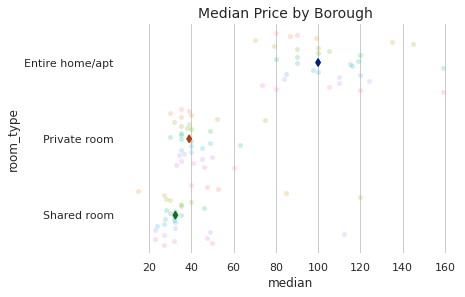

In [28]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="median", y="room_type", hue="name",
              data=la_data2, dodge=True, alpha=.25, zorder=1)
g.legend_.remove()

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data2.groupby('room_type').agg('median').reset_index(), 
              dodge=.232, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

plt.gcf().subplots_adjust(top=0.92)
f.suptitle('Median Price by Borough', fontsize=14);

#### Airbnb listings median price by 5 area in London

In [36]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
print(len(mapping.keys()))

33


In [30]:
la_data3 = gdf_la.set_index('NAME').groupby([mapping,'room_type']).agg(
    {'price':['mean','median']}
).reset_index()

In [31]:
la_data3.sample(3, random_state=42)

level_0        room_type       price       
                                        mean median
9   Outer South  Entire home/apt  120.185435     90
11  Outer South      Shared room   57.925926     40
0    Inner East  Entire home/apt  131.613156    102

In [32]:
la_data3.columns = la_data3.columns.droplevel(0)
cols = la_data3.columns.values
cols[0]  = 'area'
cols[1]  = 'room_type'
la_data3.columns = cols

In [33]:
la_data3.head(3)

,area,room_type,mean,median
0,Inner East,Entire home/apt,131.613156,102
1,Inner East,Private room,54.086745,40
2,Inner East,Shared room,68.445983,25


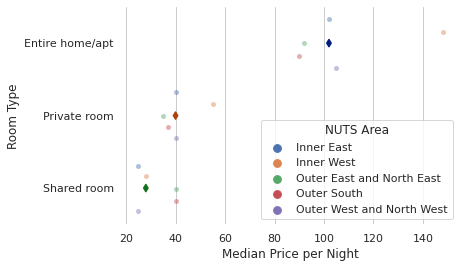

In [35]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="median", y="room_type", hue="area",
              data=la_data3, dodge=True, alpha=.45, zorder=1)
g.legend_.set_title('NUTS Area')

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data3.groupby('room_type').agg('median').reset_index(), 
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# See if you can work out how to set the plot x- and y-labels...
plt.xlabel('Median Price per Night')
plt.ylabel('Room Type');

#### Choose one borough to study

In [37]:
LA = 'Newham'

In [38]:
msoadf  = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            msoas[msoas.Borough==LA], op='within')

In [39]:
msoagrdf = msoadf.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()

In [40]:
msoagrdf.columns = msoagrdf.columns.get_level_values(1)
msoagrdf.head()

,,median,count
0,Newham 001,25.0,43
1,Newham 002,54.0,5
2,Newham 003,40.0,22
3,Newham 004,29.0,25
4,Newham 005,26.0,15


In [41]:
msoagrdf.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)

In [42]:
msoa_gdf = msoagrdf.set_index('MSOA11NM').join(
                msoas[msoas.Borough==LA].set_index('MSOA11NM'), 
                rsuffix='_r')
msoa_gdf.head(3)

,median,listings,OBJECTID,MSOA11CD,BNG_E,BNG_N,Borough,msoa11hclnm,geometry
MSOA11NM,,,,,,,,,
Newham 001,25.0,43,690,E02000714,540348,185731,Newham,Forest Gate North,"POLYGON ((540352.125 186159.250, 540398.245 18..."
Newham 002,54.0,5,691,E02000715,542928,185764,Newham,Little Ilford West,"POLYGON ((543043.169 185991.215, 543049.993 18..."
Newham 003,40.0,22,692,E02000716,541976,185969,Newham,Manor Park North,"POLYGON ((542600.490 186497.369, 542644.438 18..."


#### plot Newham Airbnb Median price

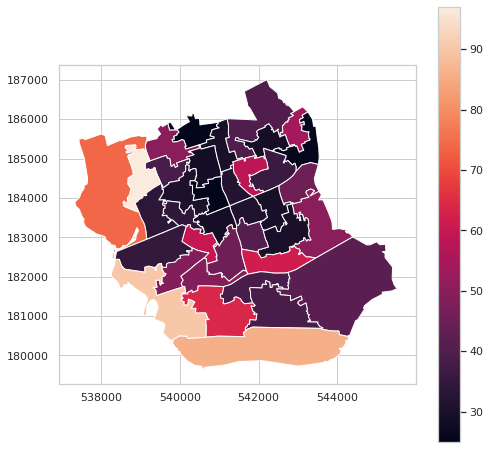

In [43]:
msoa_gdf = msoa_gdf.set_geometry('geometry')
msoa_gdf.plot(column='median', legend=True, figsize=(8,8));

In [44]:

loc = matplotlib.get_cachedir()
!ls {loc}

fontlist-v330.json


In [45]:
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
print(fonts)

['ITC Zapf Dingbats', 'cmex10', 'Utopia', 'LMRomanUnsl10', 'Symbol', 'Liberation Sans', 'New Century Schoolbook', 'LMSans10', 'cmtt10', 'ZapfDingbats', 'cmss10', 'cmb10', 'Helvetica', 'LMRomanDunh10', 'LMMonoLt10', 'DejaVu Sans Display', 'STIXGeneral', 'STIXSizeTwoSym', 'STIXNonUnicode', 'cmr10', 'STIXSizeFiveSym', 'LMMonoProp10', 'cmsy10', 'Bitstream Charter', 'Liberation Serif', 'cmmi10', 'LMRoman10', 'LMMono10', 'LMSansDemiCond10', 'DejaVu Serif Display', 'DejaVu Sans', 'LMMonoCaps10', 'LMRomanCaps10', 'LMMonoSlant10', 'LMRomanDemi10', 'LMSansQuot8', 'LMRomanSlant10', 'Computer Modern', 'Palatino', 'DejaVu Serif', 'Times', 'STIXSizeOneSym', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'ITC Avant Garde Gothic', 'Liberation Sans Narrow', 'STIXSizeFourSym', 'LMMonoLtCond10', 'LMMonoPropLt10', 'Courier', 'ITC Zapf Chancery', 'Liberation Mono', 'ITC Bookman']


In [46]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

#### Plot median price and number of listings for Newham

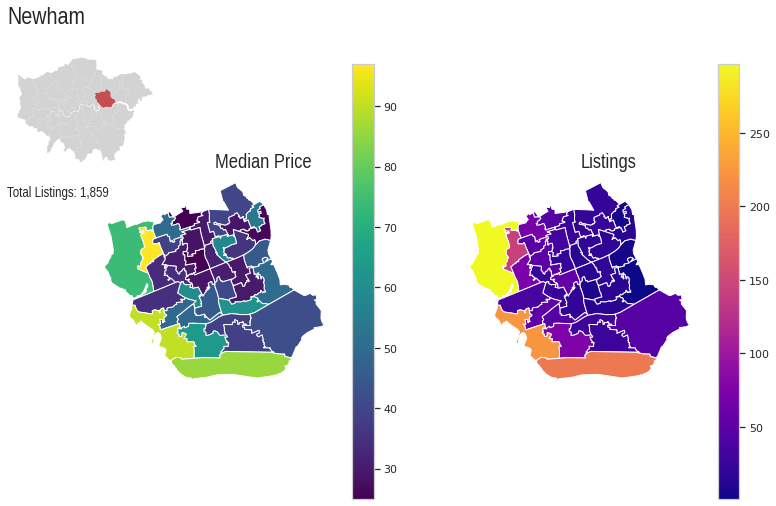

In [47]:
f,axes = plt.subplots(1,2,figsize=(12,8))

msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

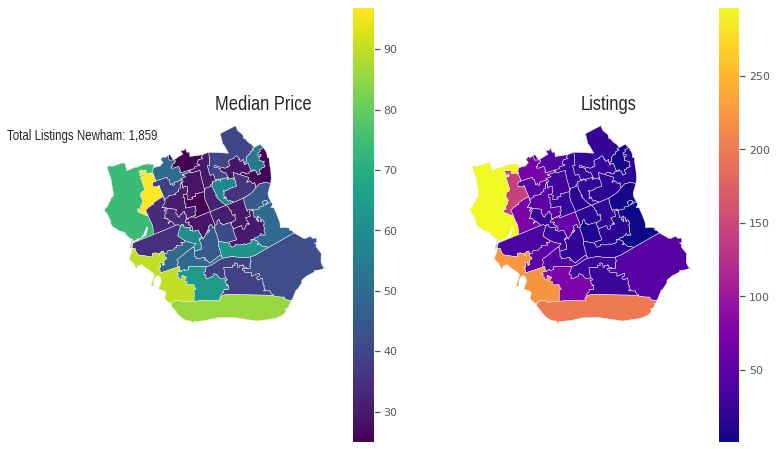

In [139]:
f,axes = plt.subplots(1,2,figsize=(12,8))

msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    

axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings Newham: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

In [48]:
from matplotlib import pyplot as plt

plt.savefig('foo.png')

<Figure size 432x288 with 0 Axes>

### Clustering

#### Scaler setup

In [57]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

#### Plot setup

In [58]:
def plt_ldn(w, b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax


# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

#### Load Water and Borough

In [59]:
# Load Water GeoPackage
w_path = os.path.join('data','geo','Water.gpkg')
if not os.path.exists(w_path):
    water = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Water.gpkg?raw=true')
    water.to_file(w_path)
    print("Downloaded Water.gpkg file.")
else:
    water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('data','geo','Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
    boroughs.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)

#### Clean MSOA data

In [60]:

msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])

KeyError: "['OBJECTID' 'MSOA11NM' 'BNG_E' 'BNG_N' 'Borough' 'msoa11hclnm'] not found in axis"

#### Plot price of the listings

<AxesSubplot:>

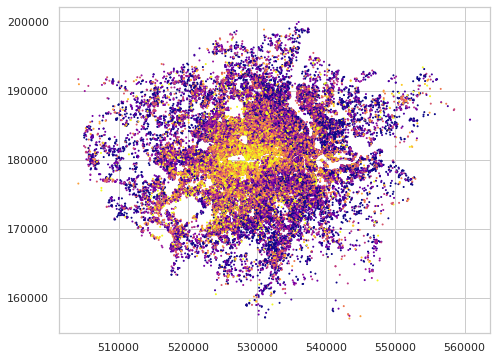

In [62]:
gdf_la.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6))

#### Dataset Number of Airbnb Listings in MSOA by Entire home/apt

In [63]:
Ablistings = gpd.sjoin(gdf_la, msoas, op='within').drop(columns=['latitude','longitude','index_right'])

In [64]:
# count room numbers by type
Ablistingscount = Ablistings.groupby(['MSOA11CD','room_type'])['price'].agg(Count='count').reset_index() 
Ablistingscount.head()

,MSOA11CD,room_type,Count
0,E02000001,Entire home/apt,384
1,E02000001,Private room,54
2,E02000001,Shared room,3
3,E02000002,Entire home/apt,2
4,E02000002,Private room,5


#### Dataset Median price Airbnb listings by MSOA

In [65]:
Ablistingprice = Ablistings.groupby('MSOA11CD')['price'].agg('median').reset_index() 
Ablistingprice.head()

,MSOA11CD,price
0,E02000001,140.00
1,E02000002,65.00
2,E02000003,45.00
3,E02000004,40.00
4,E02000005,31.00


In [66]:
# max MSOA median price
Ablistingprice.max()

MSOA11CD    E02006931
price          250.00
dtype: object

In [67]:
# min MSOA median price
Ablistingprice.min()

MSOA11CD    E02000001
price           15.00
dtype: object

In [68]:
# pivot table show the current dataset
Ablistingscount.pivot(index='MSOA11CD',columns=['room_type'], values=['Count']).reset_index()

MSOA11CD           Count                         
room_type            Entire home/apt Private room Shared room
0          E02000001          384.00        54.00        3.00
1          E02000002            2.00         5.00         nan
2          E02000003            6.00        13.00         nan
3          E02000004            1.00         4.00         nan
4          E02000005            2.00         8.00         nan
..               ...             ...          ...         ...
976        E02006927           22.00        20.00        1.00
977        E02006928           60.00        64.00        1.00
978        E02006929          108.00        90.00         nan
979        E02006930           61.00        64.00        1.00
980        E02006931           70.00        48.00        2.00

[981 rows x 4 columns]

#### Transformed listing median price by MSOA for
1. Entire home/apt
2. Private room

In [70]:
Ablistingscount = Ablistingscount.pivot(index='MSOA11CD', columns=['room_type'], values=['Count']).reset_index()
Ablistingscount.columns = ['MSOA11CD','Entire home/apt','Private room','Shared room']
Ablistingscount.drop(columns=['Shared room'], inplace=True)
Ablistingscount.head()

,MSOA11CD,Entire home/apt,Private room
0,E02000001,384.00,54.00
1,E02000002,2.00,5.00
2,E02000003,6.00,13.00
3,E02000004,1.00,4.00
4,E02000005,2.00,8.00


#### Merge to dataset

In [71]:
AblistingsG = pd.merge(Ablistingscount, Ablistingprice, on='MSOA11CD')
AblistingsG = AblistingsG.fillna(0).set_index('MSOA11CD')
AblistingsG.head()

,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,384.00,54.00,140.00
E02000002,2.00,5.00,65.00
E02000003,6.00,13.00,45.00
E02000004,1.00,4.00,40.00
E02000005,2.00,8.00,31.00


In [73]:
for c in AblistingsG.columns.values:
    AblistingsG[c] = pts.fit_transform(AblistingsG[c].values.reshape(-1,1))
AblistingsG.head(3)

,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,1.98,0.87,2.00
E02000002,-1.09,-1.27,0.43
E02000003,-0.50,-0.50,-0.45


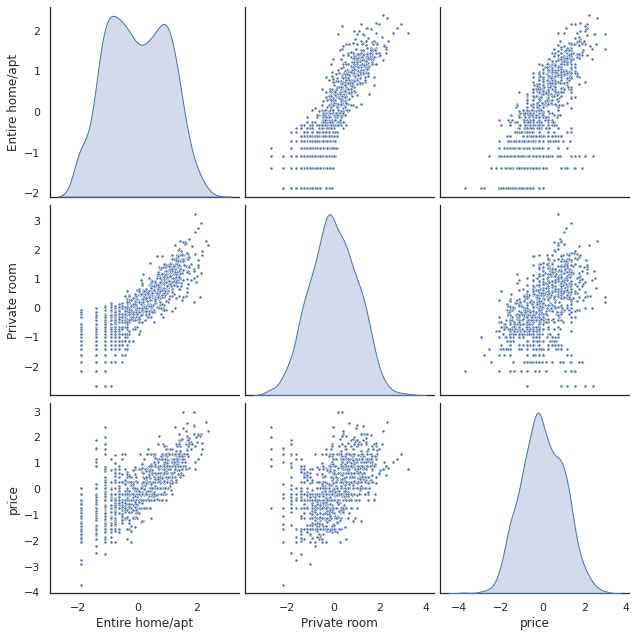

In [74]:
sns.set(style="white")
sns.pairplot(AblistingsG, markers=".", height=3, diag_kind='kde');

#### Load Median house price and affordability ratio MSOA

In [79]:
Housep = pd.read_csv(os.path.join('https://github.com/RuoxuanHong/i2pAssessment/raw/main/Median%20house%20price%20MSOA.csv'), low_memory=False, 
                 usecols=['MSOAcode','median house price','affordability ratio'])
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")
Housep.head()

Data frame is 79,647 x 7


,MSOAcode,median house price,affordability ratio
0,E02000001,"924,950.00",14.58
1,E02000002,"323,500.00",10.65
2,E02000003,"310,000.00",9.25
3,E02000004,"350,000.00",9.96
4,E02000005,"312,500.00",10.00


In [80]:
# set to MSOA code to index
Housep = Housep.fillna(0).set_index('MSOAcode')
Housep.head()

,median house price,affordability ratio
MSOAcode,,
E02000001,"924,950.00",14.58
E02000002,"323,500.00",10.65
E02000003,"310,000.00",9.25
E02000004,"350,000.00",9.96
E02000005,"312,500.00",10.00


In [81]:
# transform
for c in Housep.columns.values:
    Housep[c] = pts.fit_transform(Housep[c].values.reshape(-1,1))
Housep.head(3)

,median house price,affordability ratio
MSOAcode,,
E02000001,1.61,0.55
E02000002,-1.42,-0.74
E02000003,-1.62,-1.48


In [82]:
# merge use MSOA code
housepmerge = pd.merge(Housep, AblistingsG, left_index=True, right_index=True)
print(housepmerge.shape)
print(type(housepmerge))

(981, 5)
<class 'pandas.core.frame.DataFrame'>


In [83]:
housepmerge.head()

,median house price,affordability ratio,Entire home/apt,Private room,price
E02000001,1.61,0.55,1.98,0.87,2.00
E02000002,-1.42,-0.74,-1.09,-1.27,0.43
E02000003,-1.62,-1.48,-0.50,-0.50,-0.45
E02000004,-1.08,-1.08,-1.38,-1.42,-0.76
E02000005,-1.59,-1.06,-1.09,-0.91,-1.45


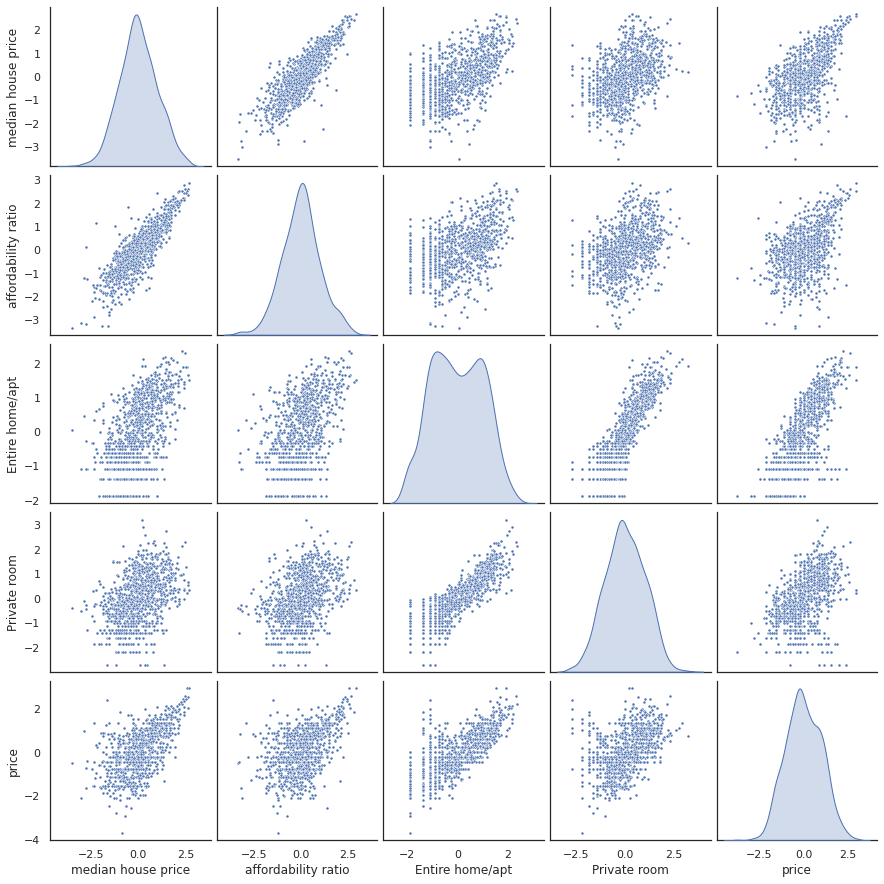

In [84]:
# plot pairplot
sns.set(style="white")
sns.pairplot(housepmerge, markers=".", height=2.5, diag_kind='kde');

#### Add median rent price

In [85]:
rent = pd.read_csv(os.path.join('https://github.com/RuoxuanHong/i2pAssessment/raw/main/Median%20rent%20price%20MSOA.csv'), low_memory=False, 
                 usecols=['area_code','quarter','median_rent_per_month'])
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")
rent.head()

Data frame is 79,647 x 7


,area_code,quarter,median_rent_per_month
0,E02000001,1,"1,950.00"
1,E02000001,2,"1,906.50"
2,E02000001,3,"1,993.00"
3,E02000001,4,"1,928.00"
4,E02000002,3,"1,350.00"


In [86]:
# count numbers by quarter 
rentc = rent.groupby(['area_code','quarter'])['median_rent_per_month'].agg(Count='count').reset_index() 
rentc.head()

,area_code,quarter,Count
0,E02000001,1,1
1,E02000001,2,1
2,E02000001,3,1
3,E02000001,4,1
4,E02000002,3,1


In [87]:
# calculat average median rent per month
rentp = rent.groupby('area_code')['median_rent_per_month'].agg('mean').reset_index() 
rentp.head()

,area_code,median_rent_per_month
0,E02000001,"1,944.38"
1,E02000002,"1,262.50"
2,E02000003,"1,293.38"
3,E02000005,"1,400.00"
4,E02000007,"1,451.75"


In [88]:
# set to area_code to index
rentp = rentp.fillna(0).set_index('area_code')
rentp.head()

,median_rent_per_month
area_code,
E02000001,"1,944.38"
E02000002,"1,262.50"
E02000003,"1,293.38"
E02000005,"1,400.00"
E02000007,"1,451.75"


In [89]:
# transform
for c in rentp.columns.values:
    rentp[c] = pts.fit_transform(rentp[c].values.reshape(-1,1))
rentp.head()

,median_rent_per_month
area_code,
E02000001,1.79
E02000002,1.07
E02000003,1.12
E02000005,1.26
E02000007,1.32


In [90]:
# merge use MSOA code
rentmerge = pd.merge(rentp, housepmerge, left_index=True, right_index=True)
print(rentmerge.shape)
print(type(rentmerge))

(937, 6)
<class 'pandas.core.frame.DataFrame'>


In [91]:
rentmerge.head()

,median_rent_per_month,median house price,affordability ratio,Entire home/apt,Private room,price
E02000001,1.79,1.61,0.55,1.98,0.87,2.00
E02000002,1.07,-1.42,-0.74,-1.09,-1.27,0.43
E02000003,1.12,-1.62,-1.48,-0.50,-0.50,-0.45
E02000005,1.26,-1.59,-1.06,-1.09,-0.91,-1.45
E02000007,1.32,-1.62,-0.99,-0.41,-0.50,-0.45


#### Rescale Data

In [92]:
# Rescale the columns using the MinMaxScaler set up in the Preamble
for c in rentmerge.columns:
    rentmerge[c] = mms.fit_transform(rentmerge[c].values.reshape(-1,1))

In [93]:
rentmerge.head()

,median_rent_per_month,median house price,affordability ratio,Entire home/apt,Private room,price
E02000001,0.11,0.66,0.25,0.82,0.20,0.67
E02000002,-0.40,-0.32,-0.17,-0.63,-0.52,0.14
E02000003,-0.37,-0.39,-0.41,-0.35,-0.26,-0.16
E02000005,-0.26,-0.37,-0.27,-0.63,-0.40,-0.50
E02000007,-0.22,-0.39,-0.25,-0.31,-0.26,-0.16


In [94]:
# results of the clustering operation
rs = pd.merge(msoas, rentmerge, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

In [95]:
rs.head()

,geometry,median_rent_per_month,median house price,affordability ratio,Entire home/apt,Private room,price
MSOA11CD,,,,,,,
E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",0.11,0.66,0.25,0.82,0.20,0.67
E02000002,"POLYGON ((548881.563 190845.265, 548881.125 19...",-0.40,-0.32,-0.17,-0.63,-0.52,0.14
E02000003,"POLYGON ((549102.438 189324.625, 548954.517 18...",-0.37,-0.39,-0.41,-0.35,-0.26,-0.16
E02000005,"POLYGON ((549099.634 187656.076, 549161.375 18...",-0.26,-0.37,-0.27,-0.63,-0.40,-0.50
E02000007,"POLYGON ((549819.924 187080.699, 549950.750 18...",-0.22,-0.39,-0.25,-0.31,-0.26,-0.16


#### K-Means Clustering

In [98]:
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(rentmerge) # The process

print(kmeans.labels_) # The results

[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1
 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 2 1 2 1 1 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 2 0
 2 1 2 2 2 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1 2 2 1 2 2 1 2 1 1 2 2 2 2 2 2 2 2 1 1 2
 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 1 0 1 1 2 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 2 2 1 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 

.......................................
Largest silhouette score was 0.4027 for k=2


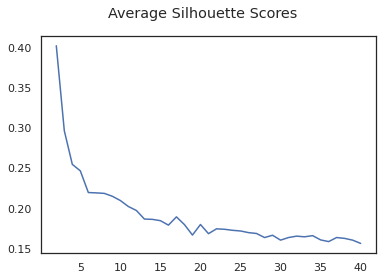

In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(rentmerge)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(rentmerge, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

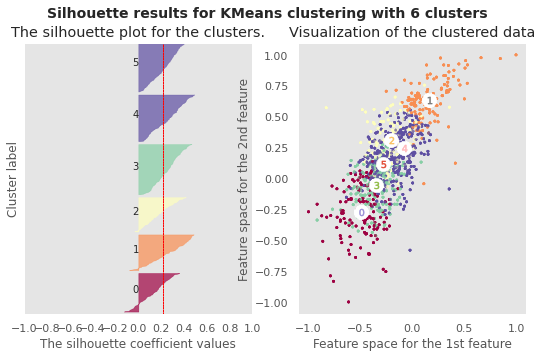

In [126]:
k_pref=6
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(rentmerge)

# Convert to a series
s = pd.Series(kmeans.labels_, index=rentmerge.index, name=c_nm)

# We do this for plotting
rs[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(rentmerge, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(rentmerge, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, rentmerge.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(rentmerge[rentmerge.columns[0]], rentmerge[rentmerge.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

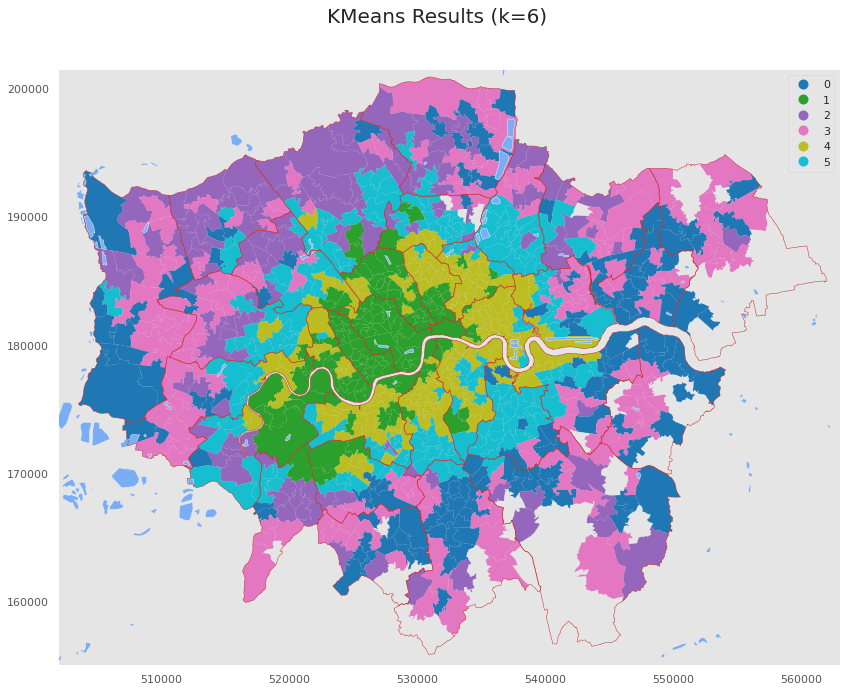

In [136]:
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);


Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5


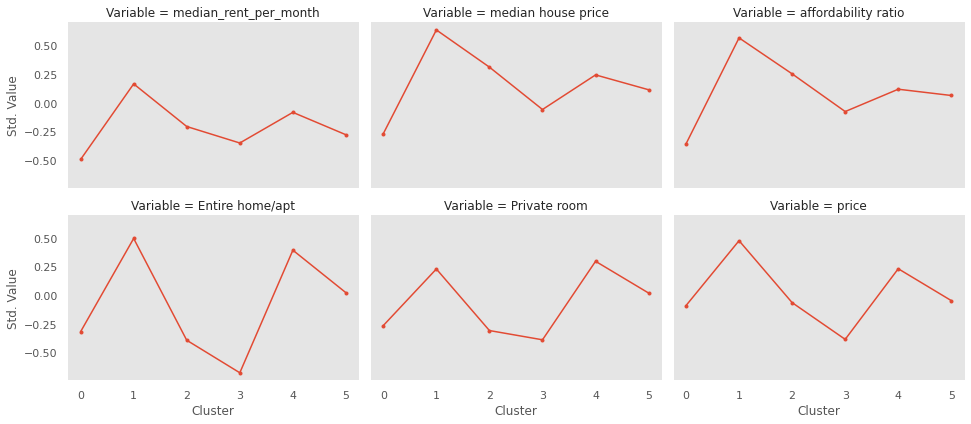

In [128]:
centroids = None
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")

    c = rs[rs[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['Borough','msoa11hclnm','Subregion','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

#### Regression

In [106]:
rentmerge.head()

,median_rent_per_month,median house price,affordability ratio,Entire home/apt,Private room,price
E02000001,0.11,0.66,0.25,0.82,0.20,0.67
E02000002,-0.40,-0.32,-0.17,-0.63,-0.52,0.14
E02000003,-0.37,-0.39,-0.41,-0.35,-0.26,-0.16
E02000005,-0.26,-0.37,-0.27,-0.63,-0.40,-0.50
E02000007,-0.22,-0.39,-0.25,-0.31,-0.26,-0.16


In [107]:
print(type(rentmerge))

<class 'pandas.core.frame.DataFrame'>


In [109]:
rentmerge.to_excel('Regression.xlsx', engine='xlsxwriter')

In [111]:
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [112]:
df = ('Regression.csv')

In [113]:
price = pd.read_csv('Regression.csv')

In [114]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MR      937 non-null    float64
 1   MH      937 non-null    float64
 2   AR      937 non-null    float64
 3   EH      937 non-null    float64
 4   PR      937 non-null    float64
 5   ALP     937 non-null    float64
dtypes: float64(6)
memory usage: 44.0 KB


In [115]:
price.head()

,MR,MH,AR,EH,PR,ALP
0,1.7929,1.6128,0.5520,1.9769,0.8680,2.0023
1,1.0726,-1.4245,-0.7412,-1.0876,-1.2658,0.4338
2,1.1176,-1.6248,-1.4794,-0.5031,-0.5015,-0.4544
3,1.2611,-1.5864,-1.0576,-1.0876,-0.9076,-1.4550
4,1.3247,-1.6248,-0.9859,-0.4130,-0.5015,-0.4544


In [116]:
price_numeric = pd.get_dummies(price)

Text(0.5, 1.0, 'Correlation Matrix')

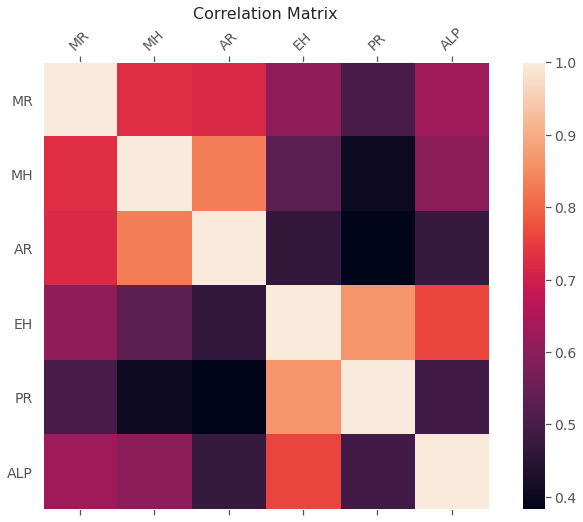

In [117]:
df = price_numeric
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [122]:
# Regression for Median rent price
MedianRentp =price_numeric.loc[:,['MR', 'EH', 'PR', 'ALP']]

In [123]:
model_Y = sm.formula.ols('MR ~ EH + PR + ALP', MedianRentp).fit()
model_Y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MR   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     246.5
Date:                Wed, 13 Jan 2021   Prob (F-statistic):          9.19e-118
Time:                        12:52:18   Log-Likelihood:                -65.885
No. Observations:                 937   AIC:                             139.8
Df Residuals:                     933   BIC:                             159.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3185      0.009    154.744      0.000       1.302       1.335
EH             0.0137      0.027      0.507      0.612      -0.039       0.067
PR             0.0825      0.021      4.015      0.000       0.042       0.123
ALP            0.1715      0.015     11.090      0.000       0.141       0.202
==============================================================================
Omnibus:                       22.890   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.244
Skew:                           0.021   Prob(JB):                     3.34e-11
Kurtosis:                       4.111   Cond. No.                         6.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# Regression for Median House price
MedianHousep =price_numeric.loc[:,['MH', 'EH', 'PR', 'ALP']]

In [125]:
model_Z = sm.formula.ols('MH ~ EH + PR + ALP', MedianHousep).fit()
model_Z.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MH   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     186.1
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.46e-94
Time:                        12:52:26   Log-Likelihood:                -1110.3
No. Observations:                 937   AIC:                             2229.
Df Residuals:                     933   BIC:                             2248.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0052      0.026      0.199      0.842      -0.046       0.056
EH             0.0769      0.082      0.933      0.351      -0.085       0.238
PR             0.1042      0.063      1.663      0.097      -0.019       0.227
ALP            0.4992      0.047     10.591      0.000       0.407       0.592
==============================================================================
Omnibus:                       43.810   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.536
Skew:                          -0.472   Prob(JB):                     2.37e-12
Kurtosis:                       3.692   Cond. No.                         6.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bar plot

In [119]:
file = pd.read_csv('https://github.com/RuoxuanHong/i2pAssessment/raw/main/Airbnblistingstotal.csv')
print(file)

                                      Time  \
0                               2,014.0500   
1                               2,015.0100   
2                               2,016.0300   
3                               2,017.0300   
4                               2,018.0400   
5                               2,019.0300   

                                     Total  \
0                              13,052.0000   
1                              21,033.0000   
2                              31,009.0000   
3                              55,198.0000   
4                              70,533.0000   
5                              79,129.0000   

                           Entire home/apt  \
0                               6,631.0000   
1                              10,914.0000   
2                              16,224.0000   
3                              28,570.0000   
4                              37,557.0000   
5                              44,042.0000   

                              P

In [104]:
name = file[:]['Time']
p1 = np.array(file[:]['Private room'])
p2 = np.array(file[:]['Others'])
p3 = np.array(file[:]['Entire home/apt'])
print(p1,p2,p3)
print(name)

[ 6421. 10119. 14785. 26628. 32246. 34345.] [  0.   0.   0.   0. 730. 742.] [ 6631. 10914. 16224. 28570. 37557. 44042.]
0   2,014.05
1   2,015.01
2   2,016.03
3   2,017.03
4   2,018.04
5   2,019.03
Name: Time, dtype: float64


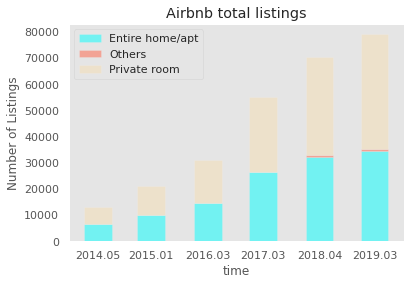

In [140]:
fig,ax = plt.subplots()
plt.bar(name,p1,color='cyan',alpha=0.5,width=0.5,label='Entire home/apt')
plt.bar(name,p2,color='tomato',alpha=0.5,width=0.5,label='Others',bottom=p1)
plt.bar(name,p3,color='wheat',alpha=0.5,width=0.5,label='Private room',bottom=p1+p2)
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of Listings')
plt.title('Airbnb total listings')
ax.set_xticks(name)
plt.show()

## Executive Briefing

#### Introduction

London is one of the most popular destinations in the UK from Airbnb report UK Insights Report. International visitors spend 118.87 million nights in London for 2019 It is about 1.26 times the total night spend in 2012 which created the much more demand for accommodations. 

Long-term renters would have a strong tend to transfer to short-term rent on Airbnb because, for example, in E0200001 MSOA that one month of rent (1944 pounds) can be achieved on Airbnb by only rent 14 days out (140 per day). Decease in the long-term rental house supply would drive up the price of rent (Barron, 2020). 


![](https://github.com/RuoxuanHong/i2pAssessment/raw/main/Airbnb%20total%20listings.jpg)


Besides, total number of listings keep increasing reached more than seventy-five thousand Airbnb listings in London for the period of 2018-2019. Which may be possible cause of London severe rental affordability problem as the expense for one bedroom counts for 46.4% of London median pre-tax income and is twice of England average from ONS statistics. The index of private housing rental prices was from 100(before Airbnb) to 108.5 now.

There are some debates around whether sharing economy influencing the local house price and rents. Therefore, policies are made to protect the local residence. 

1.	90-days rule applied to London short-term hosts to not exceed the 90 days limit. 
2.	Social homes are introduced at lower price than private rent but total number of social rents did not have much increase but the demand for it jumped.


#### Borough level study

![](https://github.com/RuoxuanHong/i2pAssessment/raw/main/Borough%20analysis%20Newham.jpg)

1.	Borough Airbnb data shows that area close to London with more listings and high price.

Take a closer look to the specific areas. The local authority Newham is chosen because it representative as belongs to Inner East area which has the median price for entire home and itself is nearly median value among 6 boroughs. From figure, areas closer to the central London have Airbnb listings with higher price and more listings. Upper middle of this area has the least listings price and top right of this area has few listings. It can be concluded that area closer to London has more Airbnb listings and higher price.


#### Cluster analysis

The next is to verify whether rental price and house price are consistent with the Airbnb listings and listing price in each area by clustering. The dataset from Urban Big Data Centre and ONS used for clustering analysis is for 2018-2019 period to avoid the possible effect of Coronavirus. 

Airbnb listings dataset:
-	Airbnb listings median price by MSOA 
-	Airbnb listings count by room type by MSOA

And some house and rental price:
-	Median house price by MSOA 
-	Median rent per month MSOA 
-	Affordability ratio MSOA (price/income)

Based on the average Silhouette score, the ‘knee’ the slope of the curve is significantly slowing down after 6 clusters. At the point with 6 clusters the curve term to be flattened. Thus, the clusters of 6 is chosen to be the best number of clusters to dataset. All clusters have nearly similar size which means the choice of cluster is reasonable and effective.



![](https://github.com/RuoxuanHong/i2pAssessment/raw/main/KMeans%20clustering.jpg)

![](https://github.com/RuoxuanHong/i2pAssessment/raw/main/Cluster%20description.jpg)

From this map, the following findings are concluded:

1.	Central London is the area with highest house price and monthly rent. At the same time, Airbnb listings price are the highest as well. This leads to the high affordability ratio which means the house price is too high related to annual household income. 


Cluster 1 areas in green are centred in central London. Central London is concentrated with visitor attractions and is reasonably has the high demand for the accommodation. Cluster 4 is mainly around cluster 1 area and is a wider range of central London. It has the second highest price and Airbnb listings. As central London has many tourists attractions. One of the most popular keywords in reviews is location which means location is important when travellers making choices of the accommodation (Cheng, 2019). Thus, good locations such as cluster 1 and 4 would have huge demand in accommodation market. Hosts with originally in long term rentals be attracted transfer to the short-term market. Taking a closer look of the Inner West area, there are in total of 28142 listings which takes 35% of the total listings in London. This would lead to the decline in the supply of long-term rentals facing to residents. Hence, lower supply of rentals may be the cause of keep increasing in both house price and monthly rents.

2.	Outer London near the boundaries have both low in the rent and house price. House within these areas are more affordable compares to other areas in London. 

Cluster 2, cluster 3, and cluster 0 show that the areas around the edge of London have more friendly price compares to other areas and has the corresponding trend of fewer Airbnb listings the lower house and rental price. 

However, a surprising discovery is that for cluster 3 shows the areas of least Airbnb listings with lowest listing prices, the house price and monthly rentals are not the lowest among all clusters. That is to some extent violate to our findings and assumptions before that house price and rentals affected by the number of the Airbnb listings. The possible reason is that the research only includes price and listing factors and did not consider other factors such as population density and percentage area for building. By checking the London greenspace map from greenspace information for Greater London, the other reason could be concluded that most areas in cluster 3 has high percentage of greenspace especially large public open space. Therefore, it is reasonable to have high house price and rental price in cluster 3 as it has better environment and less space of building compares to cluster 0 which has lowest median rent and house price but not least listings. 

#### Regression Analysis

From clustering analysis, the rental and hose level is mainly consistent with the Airbnb listings and price. The next step is to find out whether Airbnb activities would influence the prices.

1.	Active Airbnb activities are the influencing factors of the rise of the price for both house and rental. The regression model of change in the number of Airbnb listings and listings price explains more of the change of the rental price (44.2%) than house price (37.4%).

From the 2 regression models constructed, increase in 1 of Airbnb listings price would relate to the increase in the 0.17 of the rent and 0.50 increase of house price. The rise of 1 Airbnb listings would relate to the 0.085 of the increase of rent and 0.104 of house price. 



#### Conclustion

Increase in Airbnb listings would indeed cause the rise in the house price and rental price. Developing tourism economy should not ignore local residence benefits. Therefore, areas within clusters 4 and 5 imminently need the government policy to support low-income renters. A tighter regulatory policy on Airbnb could be posed and revaluate and improve of current policies is necessary.




#### Reference

Adamiak, C., Szyda, B., ... García-Álvarez, D., (2019). ‘Airbnb offer in Spain-Spatial analysis of the pattern and determinants of its distribution’, ISPRS International Journal of Geo-Information, 8. doi:10.3390/ijgi8030155 

Gibbs, C., D. Guttentag, U. Gretzel, J. Morton, and A. Goodwill, (2017). ‘Pricing in the Sharing Economy: A Hedonic Pricing Model Applied to Airbnb Listings.’, Journal of Travel & Tourism Marketing, 35, (1), pp46-56. https://doi.org/https://doi.org/10.1080/10548408.2017.1308292.

Barron, K., Kung, E., Proserpio, D., (2020). ‘The Effect of Home-Sharing on House Prices and Rents: Evidence from Airbnb’, Marketing Science. doi:10.1287/mksc.2020.1227

Cheng, M., & Jin, X. (2019). ‘What do Airbnb users care about? An analysis of online review comments.’, International Journal of Hospitality Management, 76, pp58–70. https://doi.org/10.1016/j.ijhm.2018.04.004
